## Imports and helper functions

In [71]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score, f1_score

N_DATA = 200

In [72]:
# helper_funcs 
def calculate_agreement(model_labels, pos_neg=None, maj_vote=None):
    if pos_neg == None:
        agreement = [int(i == j) for i, j in zip(model_labels, maj_vote)]
        return agreement, np.mean(agreement), len(agreement)
    elif pos_neg == 1:
        agreement = [int(i == j) for i, j in zip(model_labels, maj_vote) if j == 1]
        return agreement, np.mean(agreement), len(agreement)
    elif pos_neg == 0:
        agreement = [int(i == j) for i, j in zip(model_labels, maj_vote) if j == 0]
        print(len(agreement))
        return agreement, np.mean(agreement), len(agreement)
    
def bootstrap_se(data, n_bootstrap=1000):
    means = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        means.append(np.mean(sample))
    return np.std(means)

def compute_roc_auc(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    return fpr, tpr, roc_auc

## Expected Information Gain (EIG) vs User Similarities

In [73]:
# EIG between users with different level similarity (Hidden)
user_sim_eig_dict = {
    'eig': 'data/expected_info_gain/eigs_5k-user_4_17.json',
    'logprob_user-4': 'data/expected_info_gain/eigs_5k-user_4.json',
    'logprob_user-17': 'data/expected_info_gain/eigs_5k-user_17.json',
}

### Compare Median EIGs for each similarity

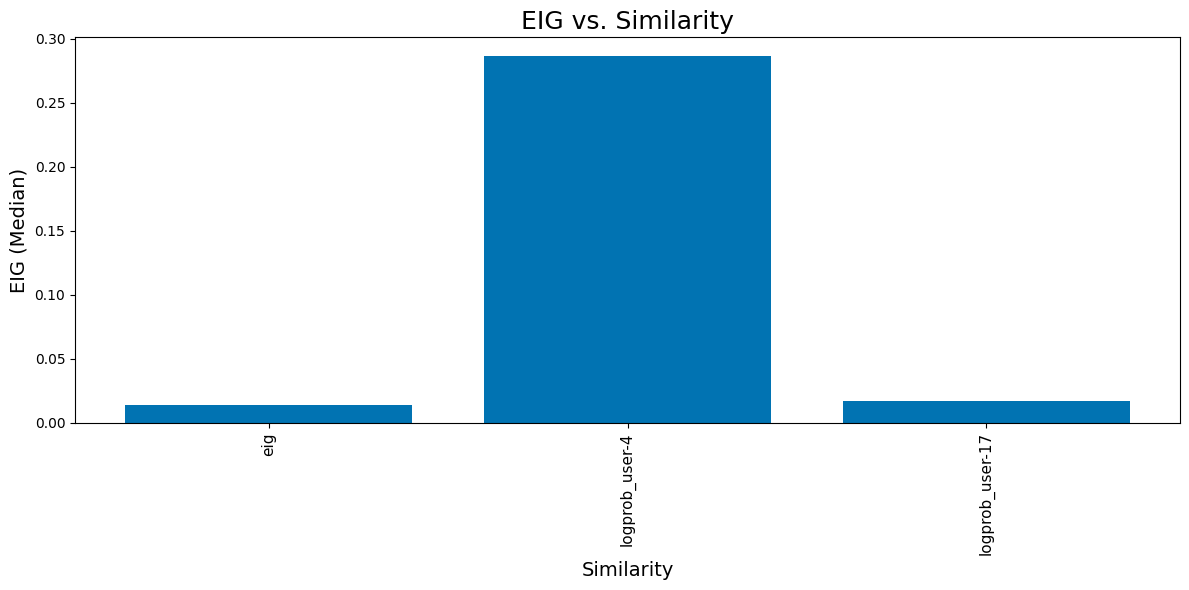

In [74]:
user_sim_eigs = {}
user_sim_median_eigs = {}

for similarity, eig_path in user_sim_eig_dict.items():        
    key = f'{similarity}'
    eig_dict = json.load(open(eig_path, 'r'))    
    best_eigs = []
    for prompt_id, prompt_eig_info in eig_dict.items():
        prompt_eig = prompt_eig_info['question_performances']    # list of EIGs across attempts
        best_question_idx = prompt_eig_info['best_question_idx']        
        prompt_best_eig = prompt_eig_info['question_performances'][best_question_idx]
        best_eigs.append(prompt_best_eig)

    user_sim_eigs[key] = best_eigs[:N_DATA]
    user_sim_median_eigs[key] = np.median(best_eigs)
    
# plot EIGS by barplot
plt.figure(figsize=(12, 6))
plt.bar(user_sim_median_eigs.keys(), user_sim_median_eigs.values())
plt.xticks(rotation=90, fontsize=11)
plt.xlabel('Similarity', fontsize=14)
plt.ylabel('EIG (Median)', fontsize=14)
plt.title('EIG vs. Similarity', fontsize=18)
plt.tight_layout()
plt.show()

        

### Compare distribution of EIGs by similarity

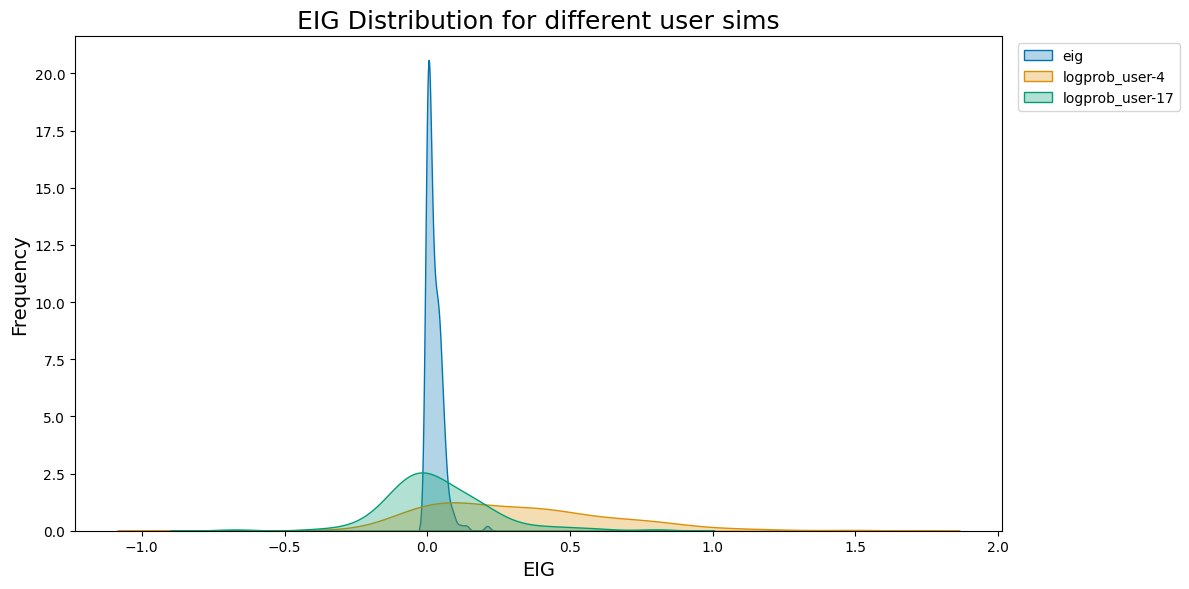

In [75]:
# plot distribution of EIGs for each similarity, using seaborn colorblind palette
plt.figure(figsize=(12, 6))
sns.set_palette('colorblind')
for user_sim, eigs in user_sim_eigs.items():    
    sns.kdeplot(eigs, label=user_sim, alpha=0.3, fill=True)
    plt.xlabel('EIG', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'EIG Distribution for different user sims', fontsize=18)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
plt.show()


## Agreement with human labels by different similarity

#### Load labels from human, GPT4, Llama3-70b and 8b

In [76]:
llama_labels = np.array(json.load(open("data/labels/llama_0_200_answer_first.json", "r")))
llama_70_labels = np.array(json.load(open("data/labels/llama_70b_0_200_question.json", "r")))
gpt4_labels = np.array(json.load(open("data/labels/gpt4_0_200_answer_first.json", "r"))["label"])
# human labels
maj_vote = np.array(json.load(open("data/labels/exp_when_9_pp_maj_votes_0_200.json", "r")))
mean_vote = np.array(json.load(open("data/labels/exp_when_9_pp_mean_votes_0_200.json", "r")))
# hold all model labels
model_labels = {
    "llama_8b": llama_labels,
    "llama_70b": llama_70_labels,
    "gpt4": gpt4_labels,
}

In [77]:
print(f"Llama-8b labels: total {len(llama_labels)}, pos {np.sum(llama_labels)}, neg {len(llama_labels) - np.sum(llama_labels)}")
print(f"Llama-70b labels: {len(llama_70_labels)}, pos {np.sum(llama_70_labels)}, neg {len(llama_70_labels) - np.sum(llama_70_labels)}")
print(f"GPT-4 labels: {len(gpt4_labels)}, pos {np.sum(gpt4_labels)}, neg {len(gpt4_labels) - np.sum(gpt4_labels)}")
print(f"Majority vote labels: {len(maj_vote)}, pos {np.sum(maj_vote)}, neg {len(maj_vote) - np.sum(maj_vote)}")
print(f"Mean vote labels: {len(mean_vote)}, pos {np.sum(mean_vote)}, neg {len(mean_vote) - np.sum(mean_vote)}")

Llama-8b labels: total 200, pos 54, neg 146
Llama-70b labels: 200, pos 91, neg 109
GPT-4 labels: 200, pos 84, neg 116
Majority vote labels: 200, pos 76, neg 124
Mean vote labels: 200, pos 77.33333333333334, neg 122.66666666666666


#### Get question labels and f1 scores for different user pairs (similarities)

In [78]:
# hand tuned costs
cost_dict = {    
    'eig': 0.0165,
    'logprob_user-4': 0.3,
    'logprob_user-17': 0.022,
}

model_vs_maj_vote_f1_scores = {}
for user_sim, eigs in user_sim_eigs.items():
    eigs = np.array(eigs)
    cost = cost_dict[user_sim]
    # print(user_sim, cost)
    # performing median split  
    labels = (eigs > cost).astype(int)
    f1 = f1_score(maj_vote, labels, average='binary')
    model_vs_maj_vote_f1_scores[user_sim] = f1
    print(user_sim, f"labels: total {len(labels)}, pos {np.sum(labels)}, neg {len(labels) - np.sum(labels)} F1: {f1:.3f}")
    model_labels[user_sim] = labels

eig labels: total 200, pos 94, neg 106 F1: 0.600
logprob_user-4 labels: total 200, pos 95, neg 105 F1: 0.632
logprob_user-17 labels: total 200, pos 96, neg 104 F1: 0.500


In [79]:
# compute F1 for each model's direct labels vs. majority vote labels
for model, labels in model_labels.items():
    if 'user' not in model:
        f1 = f1_score(maj_vote, labels, average="binary")
        model_vs_maj_vote_f1_scores[model] = f1
        print(f"F1 score for {model} vs. majority vote: {f1}")

F1 score for llama_8b vs. majority vote: 0.5230769230769231
F1 score for llama_70b vs. majority vote: 0.7305389221556886
F1 score for gpt4 vs. majority vote: 0.7125
F1 score for eig vs. majority vote: 0.6


In [80]:
# user_sim_eigs['eig_label'] = model_labels['eig']
# user_sim_eigs['logprob_user-4_label'] = model_labels['logprob_user-4']
# user_sim_eigs['logprob_user-17_label'] = model_labels['logprob_user-17']

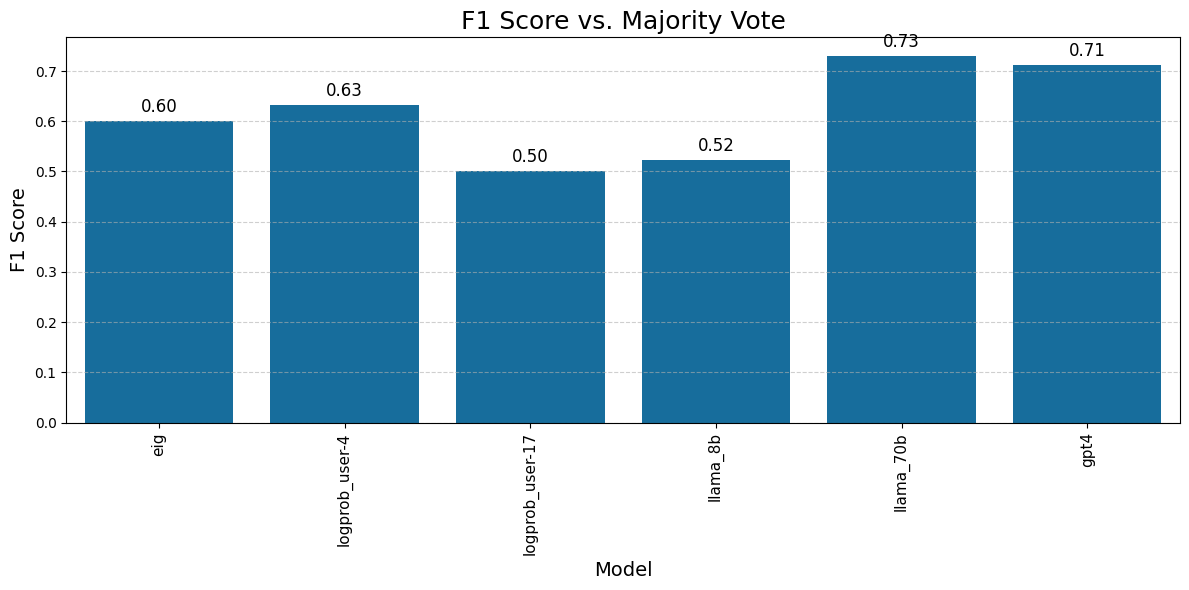

In [81]:
# plot F1 scores, with number on top of each bar
sns.set_palette('colorblind')
plt.figure(figsize=(12, 6))
sns.barplot(x=list(model_vs_maj_vote_f1_scores.keys()), y=list(model_vs_maj_vote_f1_scores.values()))
for i, v in enumerate(model_vs_maj_vote_f1_scores.values()):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=12)
plt.xticks(rotation=90, fontsize=11)
plt.xlabel('Model', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.title('F1 Score vs. Majority Vote', fontsize=18)
plt.tight_layout()

### ROC for different similarities

In [82]:
# custom_palette = sns.color_palette("hsv", 15)
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
                  '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', 
                  '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5']

#### Model prompt decision vs. MI with different similarity (Only the best two)

In [85]:
# Add LM results to user_sim_eigs
for model, labels in model_labels.items():
    if model not in ['logprob_user-4', 'logprob_user-17', 'eig']:
        user_sim_eigs[model] = labels

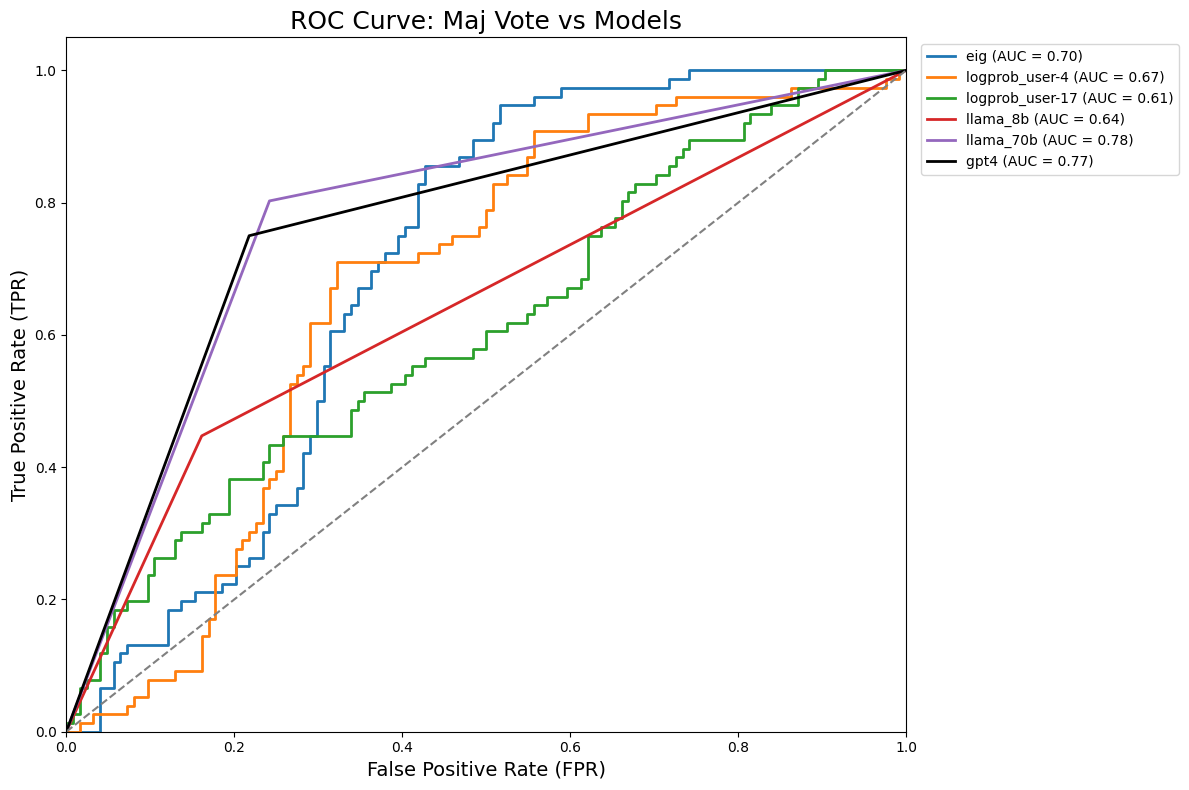

In [86]:
plt.figure(figsize=(12, 8))
sns.set_palette('colorblind')
# for i, (model, labels) in enumerate(model_labels.items()):    
for i, (model, labels) in enumerate(user_sim_eigs.items()):
    # if ('user-' in model) or 'user' not in model:
    if True:
        fpr, tpr, roc_auc = compute_roc_auc(maj_vote, labels)
        color = custom_palette[i]
        if model == 'gpt4':
            plt.plot(fpr, tpr, lw=2, color='black', label=f'{model} (AUC = {roc_auc:.2f})')    
        else:
            plt.plot(fpr, tpr, lw=2, color=color, label=f'{model} (AUC = {roc_auc:.2f})')    
    
# baseline: random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve: Maj Vote vs Models', fontsize=18)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

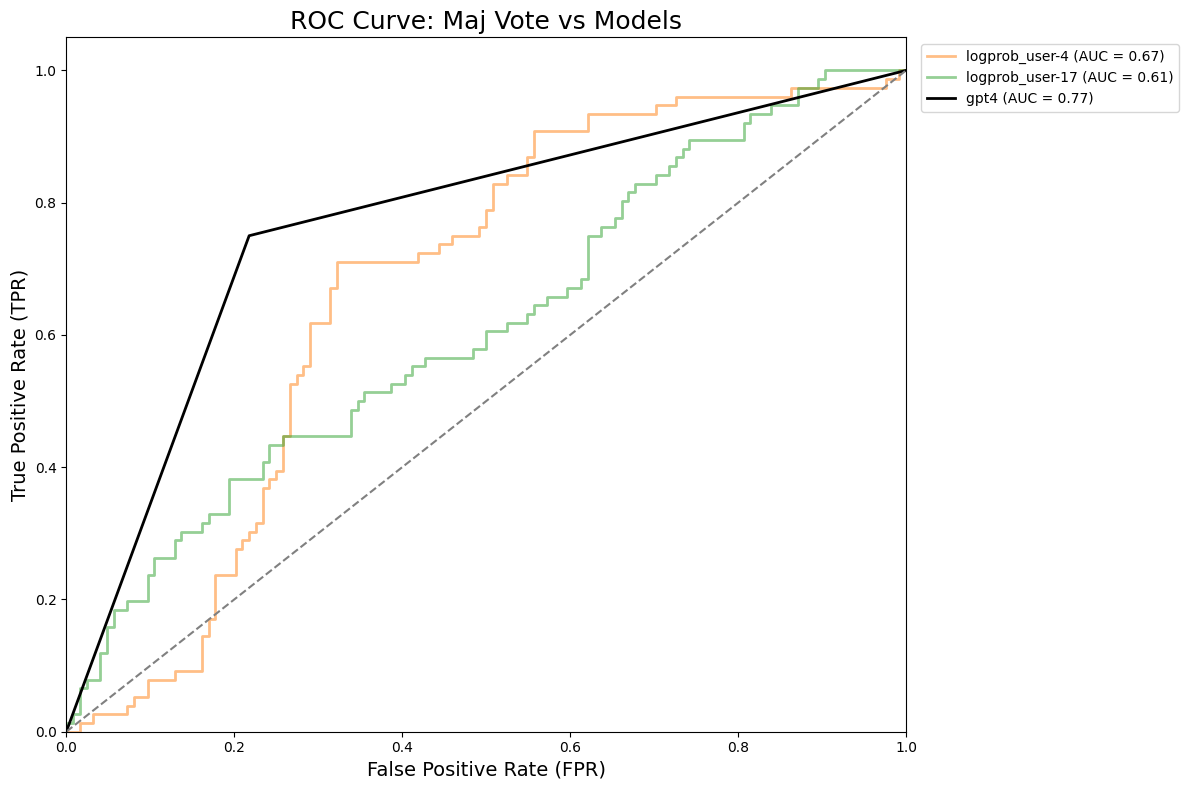

In [87]:
plt.figure(figsize=(12, 8))
# sns.set_palette('colorblind')
# for i, (model, labels) in enumerate(model_labels.items()):
    # fpr, tpr, roc_auc = compute_roc_auc(maj_vote, labels)
for i, (model, eigs) in enumerate(user_sim_eigs.items()):
    fpr, tpr, roc_auc = compute_roc_auc(maj_vote, eigs)
    color = custom_palette[i]
    if 'user' in model or 'logprob' in model:        
        plt.plot(fpr, tpr, lw=2, color=color, label=f'{model} (AUC = {roc_auc:.2f})', alpha=0.5)
    elif model == 'gpt4':
        plt.plot(fpr, tpr, lw=2, color='black', label=f'{model} (AUC = {roc_auc:.2f})')

    
# baseline: random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve: Maj Vote vs Models', fontsize=18)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Other stuff

In [58]:
three_words = json.load(open("data/expected_info_gain/debug/3_words.json", "r"))
three_words = [v["question_performances"][0] for v in three_words.values()]
ten_words = json.load(open("data/expected_info_gain/debug/10_words.json", "r"))
ten_words = [v["question_performances"][0] for v in ten_words.values()]
thirty_words = json.load(open("data/expected_info_gain/debug/30_words.json", "r"))
thirty_words = [v["question_performances"][0] for v in thirty_words.values()]
fifty_words = json.load(open("data/expected_info_gain/debug/50_words.json", "r"))
fifty_words = [v["question_performances"][0] for v in fifty_words.values()]

ten_words_turn_2 = json.load(open("data/expected_info_gain/10_words_turn_2.json", "r"))["average_eig_across_users"]
ten_words_turn_2 = [ten_words_turn_2[i] for i in range(0, len(ten_words_turn_2), 2)]
# print(ten_words_turn_2)
llama_labels = json.load(open("data/labels/llama_0_200_answer_first.json", "r"))
llama_70_labels = json.load(open("data/labels/llama_70b_0_200_question.json", "r"))
gpt4_labels = json.load(open("data/labels/gpt4_0_200_answer_first.json", "r"))["label"]
maj_vote = json.load(open("data/labels/exp_when_9_pp_maj_votes_0_200.json", "r"))
mean_vote = json.load(open("data/labels/exp_when_9_pp_mean_votes_0_200.json", "r"))

In [59]:
# find best cost param:
cost = 0.015
three_words_median_split = [1 if datum > cost else 0 for datum in ten_words_turn_2][:N_DATA]

print("MI", three_words_median_split.count(1))
mi_agreement_combined, mean_mi_agreement_combined, n_mi_combined = calculate_agreement(three_words_median_split, pos_neg=None, maj_vote=maj_vote)
mi_agreement_answer_dir, mean_mi_agreement_answer_dir, n_mi_answer_dir = calculate_agreement(three_words_median_split, pos_neg=0, maj_vote=maj_vote)
mi_agreement_ask_question, mean_mi_agreement_ask_question, n_mi_ask_question = calculate_agreement(three_words_median_split, pos_neg=1, maj_vote=maj_vote)
print(mean_mi_agreement_combined, mean_mi_agreement_answer_dir, mean_mi_agreement_ask_question)
print(llama_labels.count(1))

MI 88
124
0.65 0.6693548387096774 0.618421052631579
54


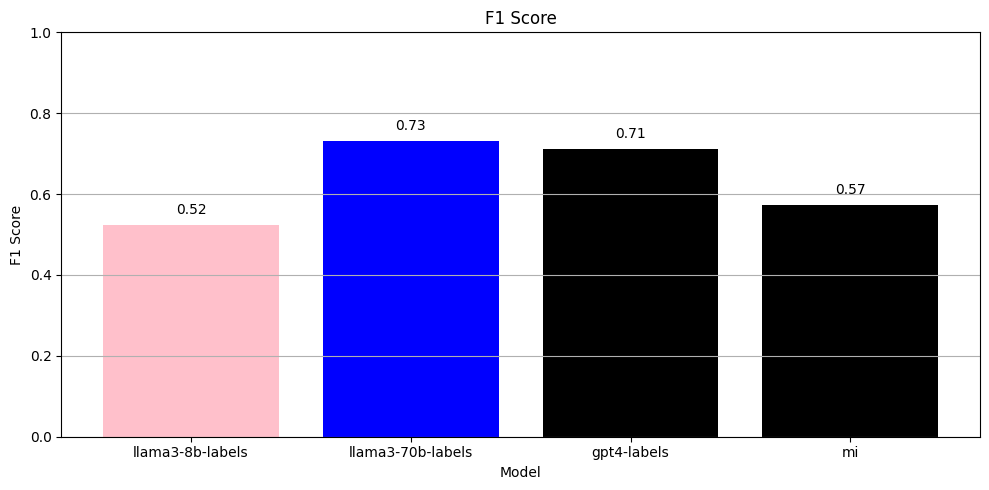

In [60]:
# Compute F1 scores for each model
llama_f1 = f1_score(maj_vote, llama_labels, average='binary')
llama_f1_70 = f1_score(maj_vote, llama_70_labels, average='binary')
gpt4_f1 = f1_score(maj_vote, gpt4_labels, average='binary')

# llama38b_behavior = json.load(open('results/base_questions_user_21_max_words_25_full_sentence.json'))
# llama370b_behavior = json.load(open('results/70b_questions.json'))
# llama_f1b = f1_score(maj_vote, llama38b_behavior, average='binary')
# llama_f1_70b = f1_score(maj_vote, llama370b_behavior, average='binary')
mi_f1 = f1_score(maj_vote, three_words_median_split , average='binary')
# mi_f2 = f1_score(maj_vote, mutual_information_median_split , average='binary')

# Plotting
models = ['llama3-8b-labels', 'llama3-70b-labels', 'gpt4-labels','mi']
f1_scores = [llama_f1, llama_f1_70, gpt4_f1, mi_f1]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(models, f1_scores, color=['pink', 'blue', 'black','black', 'pink', 'blue'])
ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score')
ax.set_ylim(0, 1)  # Setting y-axis limit from 0 to 1 for F1 score
ax.grid(axis='y')

# Adding text annotations with the exact F1 scores on top of each bar
for i, score in enumerate(f1_scores):
    ax.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

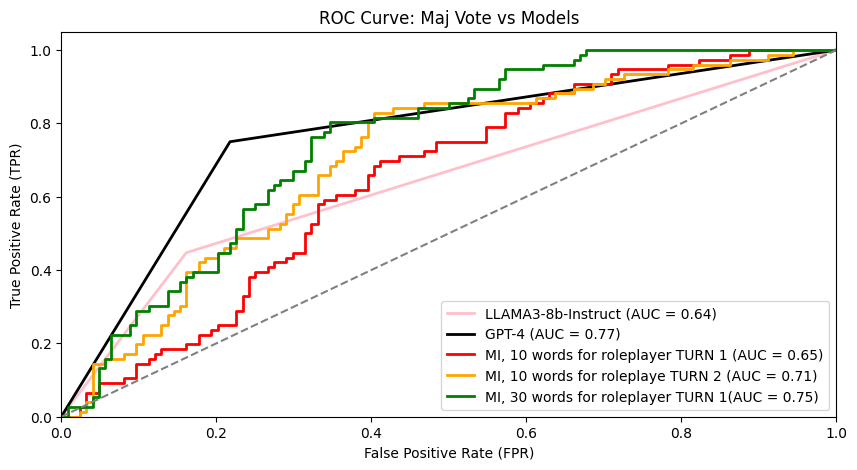

In [61]:
# Compute ROC curves f
fpr_llama, tpr_llama, roc_auc_llama = compute_roc_auc(maj_vote, llama_labels)
fpr_gpt4, tpr_gpt4, roc_auc_gpt4 = compute_roc_auc(maj_vote, gpt4_labels)

fpr_mi_3, tpr_mi_3, roc_auc_mi_3 = compute_roc_auc(maj_vote, three_words)
fpr_mi_10, tpr_mi_10, roc_auc_mi_10 = compute_roc_auc(maj_vote, ten_words)
fpr_mi_30, tpr_mi_30, roc_auc_mi_30 = compute_roc_auc(maj_vote, thirty_words)
fpr_mi_50, tpr_mi_50, roc_auc_mi_50 = compute_roc_auc(maj_vote, fifty_words)

fpr_mi_10_turn_2, tpr_mi_10_turn_2, roc_auc_mi_10_turn_2 = compute_roc_auc(maj_vote, ten_words_turn_2)

plt.figure(figsize=(10, 5))
plt.plot(fpr_llama, tpr_llama, color='pink', lw=2, label=f'LLAMA3-8b-Instruct (AUC = {roc_auc_llama:.2f})')
plt.plot(fpr_gpt4, tpr_gpt4, color='black', lw=2, label=f'GPT-4 (AUC = {roc_auc_gpt4:.2f})')

# plt.plot(fpr_mi_3, tpr_mi_3, color='blue', lw=2, label=f'MI, 3 words for roleplayer (AUC = {roc_auc_mi_3:.2f})')
plt.plot(fpr_mi_10, tpr_mi_10, color='red', lw=2, label=f'MI, 10 words for roleplayer TURN 1 (AUC = {roc_auc_mi_10:.2f})')
# plt.plot(fpr_mi_50, tpr_mi_50, color='purple', lw=2, label=f'MI, 50 words for roleplayer (AUC = {roc_auc_mi_50:.2f})')
plt.plot(fpr_mi_10_turn_2, tpr_mi_10_turn_2, color='orange', lw=2, label=f'MI, 10 words for roleplaye TURN 2 (AUC = {roc_auc_mi_10_turn_2:.2f})')

plt.plot(fpr_mi_30, tpr_mi_30, color='green', lw=2, label=f'MI, 30 words for roleplayer TURN 1(AUC = {roc_auc_mi_30:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: Maj Vote vs Models')
plt.legend(loc="lower right")
plt.show()

# 'pink', 'blue', 'black', 'pink', 'blue'

In [62]:
# Load behavior data 

stargate_epoch_1 = json.load(open('results/no_cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5.json'))
stargate_epoch_2 = json.load(open('results/no_cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5.json'))


stargate_epoch_1_cot = json.load(open('results/cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5.json'))
stargate_epoch_2_cot = json.load(open('results/cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5.json'))

stargate_epoch_1_cot_eig = json.load(open('results/cot_ckpt_1_questions_eig.json'))
stargate_epoch_2_cot_eig = json.load(open('results/cot_ckpt_2_questions_eig.json'))
print(stargate_epoch_1_cot_eig)

FileNotFoundError: [Errno 2] No such file or directory: 'results/no_cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5.json'

In [ ]:
# Compute F1 scores for each model
llama_lf = f1_score(maj_vote, llama_labels, average='binary')
gpt4_f1 = f1_score(maj_vote, gpt4_labels, average='binary')
mi = f1_score(maj_vote, mutual_information_median_split, average='binary')

llama_f1 = f1_score(maj_vote, llama38b_behavior, average='binary')
stargate_f1_epoch_1 = f1_score(maj_vote, stargate_epoch_1, average='binary')
stargate_f1_epoch_2 = f1_score(maj_vote, stargate_epoch_2, average='binary')
stargate_f1_epoch_1_cot = f1_score(maj_vote, stargate_epoch_1_cot , average='binary')
stargate_f1_epoch_2_cot = f1_score(maj_vote, stargate_epoch_2_cot, average='binary')
stargate_f1_epoch_1_cot_eig = f1_score(maj_vote, stargate_epoch_1_cot_eig , average='binary')
stargate_f1_epoch_2_cot_eig = f1_score(maj_vote, stargate_epoch_2_cot_eig, average='binary')

# Plotting
models = ['llama3-labels', 'gpt4-labels', 'mut info-labels', 'llama', 'stargate_epoch_1', 'stargate_epoch_2', 'stargate_epoch_1-cot', 'stargate_epoch_2-cot', 'stargate_epoch_1-cot-eig', 'stargate_epoch_2-cot-eig']
f1_scores = [llama_lf, gpt4_f1, mi, llama_f1, stargate_f1_epoch_1, stargate_f1_epoch_2, stargate_f1_epoch_1_cot, stargate_f1_epoch_2_cot, stargate_f1_epoch_1_cot_eig, stargate_f1_epoch_2_cot_eig]
print(len(models), len(f1_scores))
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(models, f1_scores, color=plt.cm.viridis(range(len(models))))

# Adding the vertical bar and labels
plt.axvline(x=2.5, color='black', linestyle='--')
ax.text(1, 1.02, 'Labels/Metrics for Labeling', ha='center', va='bottom', fontsize=12)
ax.text(5, 1.02, 'Inference Behavior', ha='center', va='bottom', fontsize=12)

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Scores by Model', fontsize=15)
ax.set_ylim(0, 1)  # Setting y-axis limit from 0 to 1 for F1 score
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax.grid(axis='y')

# Adding text annotations with the exact F1 scores on top of each bar
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:


# Compute ROC AUC
fpr_llama, tpr_llama, roc_auc_llama = compute_roc_auc(maj_vote, llama38b_behavior)
fpr_epoch_1_no_cot, tpr_epoch_1_no_cot, roc_auc_epoch_1_no_cot = compute_roc_auc(maj_vote, stargate_epoch_1)
fpr_epoch_2_no_cot, tpr_epoch_2_no_cot, roc_auc_epoch_2_no_cot = compute_roc_auc(maj_vote, stargate_epoch_2)
fpr_epoch_1, tpr_epoch_1, roc_auc_epoch_1 = compute_roc_auc(maj_vote, stargate_epoch_1_cot)
fpr_epoch_2, tpr_epoch_2, roc_auc_epoch_2 = compute_roc_auc(maj_vote, stargate_epoch_2_cot)
fpr_epoch_1_eig, tpr_epoch_1_eig, roc_auc_epoch_1_eig = compute_roc_auc(maj_vote, stargate_epoch_1_cot_eig)
fpr_epoch_2_eig, tpr_epoch_2_eig, roc_auc_epoch_2_eig = compute_roc_auc(maj_vote, stargate_epoch_2_cot_eig)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_llama, tpr_llama, color='blue', lw=2, label=f'LLAMA3-8b-Instruct (AUC = {roc_auc_llama:.2f})')
plt.plot(fpr_epoch_1_no_cot, tpr_epoch_1_no_cot, color='red', lw=2, label=f'STaR-GATE Epoch-1 (AUC = {roc_auc_epoch_1_no_cot:.2f})')
plt.plot(fpr_epoch_2_no_cot, tpr_epoch_2_no_cot, color='green', lw=2, label=f'STaR-GATE Epoch-2 (AUC = {roc_auc_epoch_2_no_cot:.2f})')
plt.plot(fpr_epoch_1, tpr_epoch_1, color='red', lw=2, label=f'STaR-GATE Epoch-1-CoT (AUC = {roc_auc_epoch_1:.2f})')
plt.plot(fpr_epoch_2, tpr_epoch_2, color='green', lw=2, label=f'STaR-GATE Epoch-2-CoT (AUC = {roc_auc_epoch_2:.2f})')
plt.plot(fpr_epoch_1_eig, tpr_epoch_1_eig, color='red', lw=2, label=f'STaR-GATE Epoch-1-CoT EIG (AUC = {roc_auc_epoch_1_eig:.2f})')
plt.plot(fpr_epoch_2_eig, tpr_epoch_2_eig, color='green', lw=2, label=f'STaR-GATE Epoch-2-CoT EIG(AUC = {roc_auc_epoch_2_eig:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: Model Behavior (i.e., did it ask a question or not) vs PP Maj Vote')
plt.legend(loc="lower right")
plt.show()


## Win Rates
We care about the following:
1. 

In [ ]:
stargate_epoch_2_2_users = json.load(open("results/v3/2_users-vs-1_user_5k-cot-distilled_win_rates.json", "r"))

In [ ]:
# Load win rates data
stargate_epoch_1_no_cot = json.load(open("results/v3/2_users-vs-1_user_5k-cot-distilled_win_rates.yaml", "r"))
# win_rates_no_cot_1 = json.load(open("results/cot_ckpt_1_win_rates_eig.json", "r"))
# win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]


stargate_epoch_1_cot = json.load(open("results/cot_ckpt_1_questions_eig.json", "r"))
win_rates_cot_1 = json.load(open("results/cot_ckpt_1_win_rates_eig.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 0]

# Calculate means and CIs
epochs = ['ckpt-1', 'ckpt-2']
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_1_nq, win_rates_no_cot_1]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_1_nq, win_rates_cot_1]

mean_no_cot = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_cot = [np.mean(win_rate) for win_rate in win_rates_cot_q]
print(mean_no_cot, mean_cot)

ci_no_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]

lens_no_cot = [len(win_rates_no_cot_1_q), len(win_rates_no_cot_1_nq), len(win_rates_no_cot_1)]
lens_cot = [len(win_rates_cot_1_q), len(win_rates_cot_1_nq), len(win_rates_cot_1)]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = np.arange(len(epochs))

# Define colors for the bars
colors = ['c', 'm', 'y']
labels = ['Question', 'No Question', 'Combined']

# Plot bars for mean_no_cot
for i, (mean, ci, length) in enumerate(zip(mean_no_cot, ci_no_cot, lens_no_cot)):
    bar = ax.bar(index[0] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Plot bars for mean_cot
for i, (mean, ci, length) in enumerate(zip(mean_cot, ci_cot, lens_cot)):
    bar = ax.bar(index[1] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Add labels and title
ax.set_xlabel('CKPT')
ax.set_ylabel('Mean Win Rate')
ax.set_title('Mean GPT4 Win Rates NOT COT Distilled LR 1e-5')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(epochs)

# Create a custom legend
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
ax.legend(custom_legend, labels)

# Add vertical line at 0.5 to represent chance
ax.axhline(y=0.5, color='grey', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Load win rates data
stargate_epoch_1_no_cot = json.load(open("results/no_cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_no_cot_1 = json.load(open("results/no_cot_ckpt_1_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]


stargate_epoch_1_cot = json.load(open("results/no_cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_cot_1 = json.load(open("results/no_cot_ckpt_2_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 0]

# Calculate means and CIs
epochs = ['ckpt-1', 'ckpt-2']
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_1_nq, win_rates_no_cot_1]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_1_nq, win_rates_cot_1]

mean_no_cot = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_cot = [np.mean(win_rate) for win_rate in win_rates_cot_q]
print(mean_no_cot, mean_cot)

ci_no_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]

lens_no_cot = [len(win_rates_no_cot_1_q), len(win_rates_no_cot_1_nq), len(win_rates_no_cot_1)]
lens_cot = [len(win_rates_cot_1_q), len(win_rates_cot_1_nq), len(win_rates_cot_1)]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = np.arange(len(epochs))

# Define colors for the bars
colors = ['c', 'm', 'y']
labels = ['Question', 'No Question', 'Combined']

# Plot bars for mean_no_cot
for i, (mean, ci, length) in enumerate(zip(mean_no_cot, ci_no_cot, lens_no_cot)):
    bar = ax.bar(index[0] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Plot bars for mean_cot
for i, (mean, ci, length) in enumerate(zip(mean_cot, ci_cot, lens_cot)):
    bar = ax.bar(index[1] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Add labels and title
ax.set_xlabel('CKPT')
ax.set_ylabel('Mean Win Rate')
ax.set_title('Mean GPT4 Win Rates NOT COT Distilled LR 1e-5')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(epochs)

# Create a custom legend
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
ax.legend(custom_legend, labels)

# Add vertical line at 0.5 to represent chance
ax.axhline(y=0.5, color='grey', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Load win rates data
stargate_epoch_1_no_cot = json.load(open("results/cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_no_cot_1 = json.load(open("results/cot_ckpt_1_win_rates_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]


stargate_epoch_1_cot = json.load(open("results/cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_cot_1 = json.load(open("results/cot_ckpt_2_win_rates_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 0]

# Calculate means and CIs
epochs = ['ckpt-1', 'ckpt-2']
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_1_nq, win_rates_no_cot_1]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_1_nq, win_rates_cot_1]

mean_no_cot = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_cot = [np.mean(win_rate) for win_rate in win_rates_cot_q]
print(mean_no_cot, mean_cot)

ci_no_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]

lens_no_cot = [len(win_rates_no_cot_1_q), len(win_rates_no_cot_1_nq), len(win_rates_no_cot_1)]
lens_cot = [len(win_rates_cot_1_q), len(win_rates_cot_1_nq), len(win_rates_cot_1)]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = np.arange(len(epochs))

# Define colors for the bars
colors = ['c', 'm', 'y']
labels = ['Question', 'No Question', 'Combined']

# Plot bars for mean_no_cot
for i, (mean, ci, length) in enumerate(zip(mean_no_cot, ci_no_cot, lens_no_cot)):
    bar = ax.bar(index[0] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Plot bars for mean_cot
for i, (mean, ci, length) in enumerate(zip(mean_cot, ci_cot, lens_cot)):
    bar = ax.bar(index[1] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Add labels and title
ax.set_xlabel('CKPT')
ax.set_ylabel('Mean Win Rate')
ax.set_title('Mean GPT4 Win Rates COT Distilled LR 1e-5')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(epochs)

# Create a custom legend
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
ax.legend(custom_legend, labels)

# Add vertical line at 0.5 to represent chance
ax.axhline(y=0.5, color='grey', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Load win rates data
stargate_epoch_1_no_cot = json.load(open("results/cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_no_cot_1 = json.load(open("results/cot_ckpt_1_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_short.json", "r"))
win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]


stargate_epoch_1_cot = json.load(open("results/cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_cot_1 = json.load(open("results/cot_ckpt_2_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_short.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 0]

# Calculate means and CIs
epochs = ['ckpt-1', 'ckpt-2']
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_1_nq, win_rates_no_cot_1]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_1_nq, win_rates_cot_1]

mean_no_cot = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_cot = [np.mean(win_rate) for win_rate in win_rates_cot_q]
print(mean_no_cot, mean_cot)

ci_no_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]

lens_no_cot = [len(win_rates_no_cot_1_q), len(win_rates_no_cot_1_nq), len(win_rates_no_cot_1)]
lens_cot = [len(win_rates_cot_1_q), len(win_rates_cot_1_nq), len(win_rates_cot_1)]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = np.arange(len(epochs))

# Define colors for the bars
colors = ['c', 'm', 'y']
labels = ['Question', 'No Question', 'Combined']

# Plot bars for mean_no_cot
for i, (mean, ci, length) in enumerate(zip(mean_no_cot, ci_no_cot, lens_no_cot)):
    bar = ax.bar(index[0] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Plot bars for mean_cot
for i, (mean, ci, length) in enumerate(zip(mean_cot, ci_cot, lens_cot)):
    bar = ax.bar(index[1] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Add labels and title
ax.set_xlabel('CKPT')
ax.set_ylabel('Mean Win Rate')
ax.set_title('Mean GPT4 Win Rates COT Distilled LR 1e-5 + TELL GPT4 TO REWARD CONCISE RESPONSES')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(epochs)

# Create a custom legend
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
ax.legend(custom_legend, labels)

# Add vertical line at 0.5 to represent chance
ax.axhline(y=0.5, color='grey', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# ONE USER 
# Load win rates data
stargate_epoch_1_no_cot = json.load(open("results/cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_no_cot_1 = json.load(open("results/cot_ckpt_1_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]


stargate_epoch_1_cot = json.load(open("results/cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_cot_1 = json.load(open("results/cot_ckpt_2_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 0]

# Calculate means and CIs
epochs = ['ckpt-1', 'ckpt-2']
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_1_nq, win_rates_no_cot_1]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_1_nq, win_rates_cot_1]

mean_no_cot = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_cot = [np.mean(win_rate) for win_rate in win_rates_cot_q]
print(mean_no_cot, mean_cot)

ci_no_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]

lens_no_cot = [len(win_rates_no_cot_1_q), len(win_rates_no_cot_1_nq), len(win_rates_no_cot_1)]
lens_cot = [len(win_rates_cot_1_q), len(win_rates_cot_1_nq), len(win_rates_cot_1)]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = np.arange(len(epochs))

# Define colors for the bars
colors = ['c', 'm', 'y']
labels = ['Question', 'No Question', 'Combined']

# Plot bars for mean_no_cot
for i, (mean, ci, length) in enumerate(zip(mean_no_cot, ci_no_cot, lens_no_cot)):
    bar = ax.bar(index[0] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Plot bars for mean_cot
for i, (mean, ci, length) in enumerate(zip(mean_cot, ci_cot, lens_cot)):
    bar = ax.bar(index[1] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Add labels and title
ax.set_xlabel('CKPT')
ax.set_ylabel('Mean Win Rate')
ax.set_title('Mean GPT4 Win Rates COT Distilled LR 1e-5')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(epochs)

# Create a custom legend
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
ax.legend(custom_legend, labels)

# Add vertical line at 0.5 to represent chance
ax.axhline(y=0.5, color='grey', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# ONE USER 
# Load win rates data
stargate_epoch_1_no_cot = json.load(open("results/cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_no_cot_1 = json.load(open("results/cot_ckpt_1_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_one_user_short.json", "r"))
win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]


stargate_epoch_1_cot = json.load(open("results/cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_cot_1 = json.load(open("results/cot_ckpt_2_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_one_user_short.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 0]

# Calculate means and CIs
epochs = ['ckpt-1', 'ckpt-2']
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_1_nq, win_rates_no_cot_1]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_1_nq, win_rates_cot_1]

mean_no_cot = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_cot = [np.mean(win_rate) for win_rate in win_rates_cot_q]
print(mean_no_cot, mean_cot)

ci_no_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]

lens_no_cot = [len(win_rates_no_cot_1_q), len(win_rates_no_cot_1_nq), len(win_rates_no_cot_1)]
lens_cot = [len(win_rates_cot_1_q), len(win_rates_cot_1_nq), len(win_rates_cot_1)]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = np.arange(len(epochs))

# Define colors for the bars
colors = ['c', 'm', 'y']
labels = ['Question', 'No Question', 'Combined']

# Plot bars for mean_no_cot
for i, (mean, ci, length) in enumerate(zip(mean_no_cot, ci_no_cot, lens_no_cot)):
    bar = ax.bar(index[0] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Plot bars for mean_cot
for i, (mean, ci, length) in enumerate(zip(mean_cot, ci_cot, lens_cot)):
    bar = ax.bar(index[1] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Add labels and title
ax.set_xlabel('CKPT')
ax.set_ylabel('Mean Win Rate')
ax.set_title('Mean GPT4 Win Rates COT Distilled LR 1e-5')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(epochs)

# Create a custom legend
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
ax.legend(custom_legend, labels)

# Add vertical line at 0.5 to represent chance
ax.axhline(y=0.5, color='grey', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
import os
gains = sorted(os.listdir("data/expected_info_gain/5k_v2/"), key=lambda item: int(item.split("_")[2]))
eigs = []
for g in gains:
    data = json.load(open(f"data/expected_info_gain/5k_v2/{g}", "r"))
    eigs.extend
